In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive, files # google colab specific
import requests
import pandas as pd
import os
import warnings
import sys
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras import layers
import math
from sklearn.metrics import mean_squared_error

In [33]:
# Read in the csv file that contains the time series data of the Shiller Index
# Create the dataframe

df = pd.read_csv('/content/drive/MyDrive/JPM/jphomevalue/data/TPXRSA.csv')
df.head()

,DATE,TPXRSA
0,2002-01-01,120.395793
1,2002-02-01,120.700034
2,2002-03-01,122.958147
3,2002-04-01,123.707047
4,2002-05-01,124.950321


In [ ]:
df.tail()

,DATE,TPXRSA
235,2021-08-01,296.829882
236,2021-09-01,304.124715
237,2021-10-01,309.713391
238,2021-11-01,315.997613
239,2021-12-01,321.813428


In [34]:
# Reset the index based on the prices
df1 = df.reset_index()['TPXRSA']
df1

0      120.395793
1      120.700034
2      122.958147
3      123.707047
4      124.950321
          ...    
235    296.829882
236    304.124715
237    309.713391
238    315.997613
239    321.813428
Name: TPXRSA, Length: 240, dtype: float64

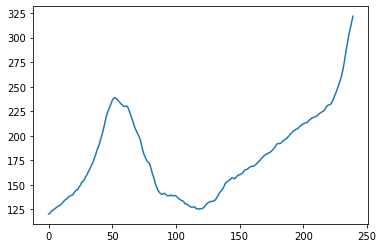

In [5]:
# Visualize the data for reference. 
plt.plot(df1)

In [35]:
# Normalize the data with the range 0 - 1
scaler = MinMaxScaler(feature_range=(0,1))

# Apply the scaler to the dataframe
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Print df1 to check the change
print(df1)

[[0.        ]
 [0.0015105 ]
 [0.0127216 ]
 [0.01643974]
 [0.02261236]
 [0.02582636]
 [0.03206009]
 [0.03653   ]
 [0.04060244]
 [0.04371508]
 [0.0489567 ]
 [0.05677053]
 [0.06392487]
 [0.07082847]
 [0.07509031]
 [0.08058354]
 [0.08798453]
 [0.09070681]
 [0.09411335]
 [0.09584313]
 [0.10658833]
 [0.11364136]
 [0.12154158]
 [0.1233108 ]
 [0.13704495]
 [0.14456247]
 [0.16022904]
 [0.16300491]
 [0.17360752]
 [0.18587374]
 [0.19638039]
 [0.20942975]
 [0.22186303]
 [0.23614469]
 [0.24919548]
 [0.26400123]
 [0.28223184]
 [0.30007263]
 [0.32206666]
 [0.33786271]
 [0.35553662]
 [0.37934439]
 [0.40075482]
 [0.42695143]
 [0.45337209]
 [0.48404356]
 [0.50729994]
 [0.52431752]
 [0.54180167]
 [0.55551435]
 [0.573843  ]
 [0.58362501]
 [0.58886697]
 [0.58370613]
 [0.57860155]
 [0.57130746]
 [0.56470713]
 [0.55591265]
 [0.55069115]
 [0.54469732]
 [0.54296735]
 [0.54637412]
 [0.54206339]
 [0.52766345]
 [0.50983095]
 [0.49174349]
 [0.47200592]
 [0.45047009]
 [0.43241851]
 [0.41873809]
 [0.40540476]
 [0.39

In [36]:
# Split data into train, validation and test set. Ratio: 6/1/3
training_size = int(len(df1)*0.4)
validation_size = int(len(df1)*0.82) 
test_size = int(len(df1))

train_set = df1[0:training_size,:]
validation_set = df1[training_size:validation_size,:]
test_set = df1[validation_size:test_size,:1]
prediction_set = df1[96:241,:]


In [ ]:
df1.shape

(240, 1)

In [37]:
# Check sizes and set sizes
#training_size
#validation_size 
#test_size
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)
print(prediction_set.shape)

(96, 1)
(100, 1)
(44, 1)
(144, 1)


In [38]:
# The current array of values needs to be converted into a dataset matrix
def create_dmatrix(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    k = dataset[i:(i + time_step), 0]
    data_X.append(k)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

In [39]:
# Using the function already created for the conversion, convert training, validation and test sets. 
time_step = 24
X_train, Y_train = create_dmatrix(train_set, time_step)
X_val, Y_val = create_dmatrix(validation_set, time_step)
X_test, Y_test = create_dmatrix(test_set, time_step)
X_pred, Y_pred = create_dmatrix(prediction_set, time_step)

print('X Train set shape:', X_train.shape)
print('y Train set shape:', Y_train.shape)

print('X Validation set shape:', X_val.shape)
print('y Validation set shape:', Y_val.shape)

print('X Test set shape:', X_test.shape)
print('y Test set shape:', Y_test.shape)

print('X Pred set shape:', X_pred.shape)
print('y Pred set shape:', Y_pred.shape)

X Train set shape: (71, 24)
y Train set shape: (71,)
X Validation set shape: (75, 24)
y Validation set shape: (75,)
X Test set shape: (19, 24)
y Test set shape: (19,)
X Pred set shape: (119, 24)
y Pred set shape: (119,)


In [ ]:
# Check the matrixes created
X_test

In [40]:
# In order to feed the dataset to the neural network the data must be in 3D

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

In [41]:
# Hyperparameters
batch_size = 16
epochs = 200
learning_rate = 0.001

In [42]:
# LSTM MODEL ARCHITECTURE

model = keras.models.Sequential([
  keras.Input(shape=(24, 1)),
  # Masking layer, to ignore zeros.
  # keras.layers.Masking(),
  # 4 LSTM Layers with 16 units.
  keras.layers.LSTM(units=250, return_sequences=True),
  keras.layers.LSTM(units=250, return_sequences=True),
  keras.layers.LSTM(units=250, return_sequences=True),
  keras.layers.LSTM(units=250),
  keras.layers.Dropout(0.5),
  # Fully Connected Layer
  keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 250)           252000    
                                                                 
 lstm_5 (LSTM)               (None, 24, 250)           501000    
                                                                 
 lstm_6 (LSTM)               (None, 24, 250)           501000    
                                                                 
 lstm_7 (LSTM)               (None, 250)               501000    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 1,755,251
Trainable params: 1,755,251
No

In [43]:
# Loss and Optimizer Functions
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
model.compile(loss=mse, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[rmse])

In [46]:
# Callbacks.

callbacks = [EarlyStopping(monitor='val_loss', patience=100, verbose=1), 
            ModelCheckpoint(filepath='/content/sample_data/lstm-model-tampa-24-0.4-2.h5', verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=False)]

# Train the model
history = model.fit(x=X_train, y=Y_train, validation_data =(X_val, Y_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callbacks)

Epoch 1/200
4/5 [=======================>......] - ETA: 0s - loss: 8.9179e-04 - root_mean_squared_error: 0.0299
Epoch 1: val_loss improved from inf to 0.00066, saving model to /content/sample_data/lstm-model-tampa-24-0.4-2.h5
5/5 [==============================] - 0s 61ms/step - loss: 8.4358e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.5939e-04 - val_root_mean_squared_error: 0.0257
Epoch 2/200
4/5 [=======================>......] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370
Epoch 2: val_loss improved from 0.00066 to 0.00064, saving model to /content/sample_data/lstm-model-tampa-24-0.4-2.h5
5/5 [==============================] - 0s 58ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 6.4079e-04 - val_root_mean_squared_error: 0.0253
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0375
Epoch 3: val_loss improved from 0.00064 to 0.00064, saving model to /content/sample_data/lstm-model-tampa-24-0.4

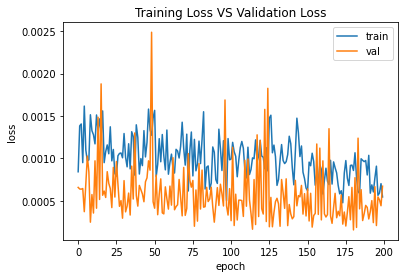

In [47]:
# Visualize loss

# Visualize training and validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss VS Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# Load model
model = keras.models.load_model('/content/drive/MyDrive/JPM/jphomevalue/model/lstm-model-tampa-24-15(1).h5')

In [48]:
# Model evaluation
test_predicted = model.predict(X_pred)

In [ ]:
test_predicted

array([[0.53790176],
       [0.5449306 ],
       [0.5473531 ],
       [0.5480422 ],
       [0.55409443],
       [0.5666542 ],
       [0.5845383 ],
       [0.6032047 ],
       [0.6208849 ],
       [0.6377298 ],
       [0.65375406],
       [0.6712957 ],
       [0.6934464 ],
       [0.7227148 ],
       [0.7599369 ],
       [0.79994565],
       [0.83564603],
       [0.86546886],
       [0.8879767 ]], dtype=float32)

In [49]:
# Apply inverse transformation
test_predicted= scaler.inverse_transform(test_predicted)
#Y_test = scaler.inverse_transform(Y_test)
#test_predicted = test_predicted.reshape(test_predicted.shape[0],test_predicted.shape[1])
#test_predicted.shape

In [28]:
#Y_test.shape
#test_predicted.shape
#test_predicted = test_predicted.reshape(test_predicted.shape[0])
test_predicted

array([[161.14645],
       [162.10031],
       [162.77263],
       [162.92213],
       [162.82004],
       [162.98225],
       [163.64381],
       [164.58076],
       [165.49796],
       [166.27548],
       [167.11482],
       [168.29442],
       [169.6384 ],
       [170.80418],
       [171.70427],
       [172.52597],
       [173.31535],
       [173.97609],
       [174.38528],
       [174.6876 ],
       [175.13689],
       [175.91061],
       [177.05746],
       [178.4576 ],
       [180.04987],
       [181.67686],
       [183.25928],
       [184.68561],
       [185.90984],
       [186.88373],
       [187.60503],
       [188.15283],
       [188.70271],
       [189.40659],
       [190.43942],
       [191.8093 ],
       [193.56517],
       [195.3996 ],
       [196.82861],
       [197.55708],
       [197.80714],
       [198.08295],
       [198.59384],
       [199.35042],
       [200.1935 ],
       [201.16444],
       [202.23227],
       [203.47615],
       [204.80663],
       [206.17484],


In [ ]:
# Re-populate Y_test
#X_test, Y_test = create_dmatrix(test_set, time_step)
#Y_test = Y_test.reshape(test_predicted.shape[0],1)
#Y_test = scaler.inverse_transform(Y_test)
#Y_test = Y_test.reshape(-1)
Y_test

array([0.69679428, 0.72444967, 0.75904152, 0.80074996, 0.84023198,
       0.87596148, 0.91217893, 0.93992563, 0.97112559])

In [24]:
# Reshape Y_test to 2D
Y_test = Y_test.reshape(test_predicted.shape[0],1)
Y_test = scaler.inverse_transform(Y_test)

# Reshape back to 1D
Y_test = Y_test.reshape(test_predicted.shape[0])
Y_test

array([231.45046524, 231.83269223, 232.80002415, 235.63291781,
       238.22681998, 241.91043322, 245.02071711, 248.77551829,
       252.58926419, 256.19233444, 260.74244789, 266.31273152,
       273.2801407 , 281.68095655, 289.63333011, 296.82988156,
       304.12471465, 309.71339095, 315.99761266])

In [50]:
# Reshape Y_pred to 2D
Y_pred = Y_pred.reshape(test_predicted.shape[0],1)
Y_pred = scaler.inverse_transform(Y_pred)

# Reshape back to 1D
Y_pred = Y_pred.reshape(test_predicted.shape[0])
Y_pred

array([125.62989394, 126.26518742, 127.05560433, 128.91891905,
       130.37099813, 131.67243908, 132.19423465, 132.94338818,
       133.16218236, 133.32216302, 133.86626158, 134.67770065,
       137.04570885, 138.69460311, 141.50160432, 143.17784015,
       144.44083847, 146.48342898, 149.11482908, 152.07384882,
       152.92803123, 153.77600683, 154.90817706, 155.88577758,
       157.26617487, 156.87661388, 156.17780098, 157.37325959,
       158.95470042, 159.99778969, 160.27166994, 160.80958306,
       161.59240029, 163.26827721, 165.17616352, 165.55410603,
       165.87182603, 166.84527884, 168.19832314, 168.68188664,
       168.91433734, 168.94534168, 169.90902371, 171.04128783,
       172.30462898, 173.71028267, 174.8973794 , 176.67670467,
       177.79124755, 179.30300157, 180.23606116, 181.27301702,
       181.906548  , 182.5129086 , 183.23624805, 184.32702694,
       185.48524594, 187.29957722, 188.81726327, 191.25350939,
       192.0606832 , 192.1530866 , 192.12507583, 193.18

In [51]:
# Calculate RMSE
math.sqrt(mean_squared_error(Y_pred,test_predicted))


11.021708536640306

In [53]:
#test_predicted = test_predicted.reshape(-1, 1)
#test_predicted
#test_predicted
print(test_predicted[118])
print(Y_pred[118])

[272.7937]
315.997612656474


In [52]:
from numpy import savetxt
np.savetxt('test_predicted.txt', test_predicted, fmt='%s')
files.download('test_predicted.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
training_predicted = model.predict(X_train)
validation_predicted = model.predict(X_val)

In [ ]:
training_predicted = scaler.inverse_transform(training_predicted)
#training_predicted.shape
validation_predicted = scaler.inverse_transform(validation_predicted)
#validation_predicted.shape
print(scaler.inverse_transform(validation_set))

[[177.79124755]
 [179.30300157]
 [180.23606116]
 [181.27301702]
 [181.906548  ]
 [182.5129086 ]
 [183.23624805]
 [184.32702694]
 [185.48524594]
 [187.29957722]
 [188.81726327]
 [191.25350939]
 [192.0606832 ]
 [192.1530866 ]
 [192.12507583]
 [193.18992211]
 [194.80182656]
 [195.52227904]
 [196.56334956]
 [197.21897219]
 [198.96773997]
 [200.01970483]
 [201.95115829]
 [203.03163447]
 [204.65713353]
 [205.50370861]
 [206.36003519]
 [206.93065877]]


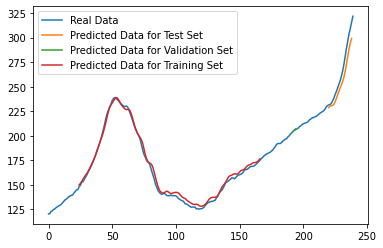

In [ ]:
# Plotting everything together
# Setting the intervals 

# shift training predictions for plotting
training_predicted_plot = np.empty_like(df1)
training_predicted_plot[:, :] = np.nan
#training_predicted.shape
#training_predicted_plot[14:167, :] = training_predicted
training_predicted_plot[24:167, :] = training_predicted

#training_predicted_plot[24:143, :] = training_predicted
# shift validation predictions for plotting
val_predicted_plot = np.empty_like(df1)
val_predicted_plot[:, :] = np.nan
#validation_predicted.shape
#val_predicted_plot[181:214, :] = validation_predicted
#val_predicted_plot[192:203, :] = validation_predicted
#val_predicted_plot[168:191, :] = validation_predicted
val_predicted_plot[192:195, :] = validation_predicted
# shift test predictions for plotting
test_predicted_plot = np.empty_like(df1)
test_predicted_plot[:, :] = np.nan
#test_predicted.shape
#test_predicted_plot[230:239, :] = test_predicted
#test_predicted_plot[228:239, :] = test_predicted
#test_predicted_plot[216:239, :] = test_predicted
test_predicted_plot[220:239, :] = test_predicted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label = "Real Data")
plt.plot(test_predicted_plot, label = "Predicted Data for Test Set")
plt.plot(val_predicted_plot, label = "Predicted Data for Validation Set")
plt.plot(training_predicted_plot, label = "Predicted Data for Training Set")
plt.legend()
plt.show()

In [ ]:
#math.sqrt(mean_squared_error(Y_test,test_predicted))
#print(scaler.inverse_transform(train_set))
#print(scaler.inverse_transform(training_predicted))
#train_set_invers = scaler.inverse_transform(Y_train)
#math.sqrt(mean_squared_error(_test,test_predicted))
#Y_train_sh = Y_train.reshape(training_predicted.shape[0],1)
#train_set_invers = scaler.inverse_transform(Y_train_sh)

#Y_train_d = Y_train.reshape(-1, 1)
#train_set_invers = scaler.inverse_transform(Y_train_d)
#math.sqrt(mean_squared_error(train_set_invers, training_predicted))
#print(scaler.inverse_transform(X_test))
#test_predicted

array([[237.0811 ],
       [240.32011],
       [243.95862],
       [248.07315],
       [252.65337],
       [257.63763],
       [262.94397],
       [268.51364],
       [274.28806]], dtype=float32)

In [ ]:
# Create new array for future predictions

# Explanation. Since we have been predicting using timestep = 24, meaning we have used the past 24 prices to predict the 25th, now we will use the test_set data as that is the latest data to predict further INTO THE UNKNOWN!
# The size of the future_input array needs to be equal to timestep, so if you change the test_data size and timestep make sure to reflect those changes here as well.

pred_input=df1[196:220].reshape(1,-1)
print(scaler.inverse_transform(pred_input))

[[207.71988729 209.17786562 210.20798447 211.30094292 212.29424721
  212.69373264 213.22358458 213.58102977 214.8471003  216.4168269
  217.1503595  218.3270374  218.52542493 219.14463903 219.79275285
  220.57041794 221.70518811 222.92313866 223.79606296 224.7245786
  225.43047908 227.02634156 229.16505202 230.73607244]]


In [ ]:
# Add that to temp input
temp_input=list(pred_input)
temp_input=temp_input[0].tolist()
temp_input 

[0.4335474119811934,
 0.4407859952970056,
 0.4459003381674812,
 0.45132666767068386,
 0.45625823331864723,
 0.4582416020009469,
 0.4608722154630688,
 0.46264686242109343,
 0.4689326602366416,
 0.47672605230864173,
 0.4803679012609835,
 0.48620988179066515,
 0.48719483790195006,
 0.4902691173302788,
 0.49348687840513594,
 0.49734783670823635,
 0.5029817533584996,
 0.5090286447137397,
 0.5133625467560822,
 0.5179724491413268,
 0.5214771099328371,
 0.5294002616466654,
 0.5400185496809672,
 0.547818365302882]

In [ ]:
# Predict in the future

from numpy import array

list_output=[]
n_steps=24
i=0
while(i<12):
    
    if(len(temp_input)>24):
        print('Entering main condition')
        #print(temp_input)
        pred_input=np.array(temp_input[1:]) # Shift one to the right
        print("{} month input {}".format(i,pred_input))
        pred_input=pred_input.reshape(1,-1)
        pred_input = pred_input.reshape(1, n_steps, 1)
        print('Pred_input shape is:', pred_input.shape)
        fut_pred = model.predict(pred_input, verbose=0)
        print("{} month output {}".format(i,fut_pred))
        temp_input.extend(fut_pred[0].tolist()) # Add that prediction to the temp input list as that will be used in the next prediction 
        temp_input=temp_input[1:] #Shift the temp_input to remove the first element which was already used in a sequence
        #print(temp_input)
        list_output.extend(fut_pred.tolist())
        i=i+1
    else:
        print('Entering else condition')
        pred_input = pred_input.reshape((1, n_steps,1))
        fut_pred = model.predict(pred_input, verbose=0)
        print('The predicted value is:',fut_pred[0])
        temp_input.extend(fut_pred[0].tolist())
        print(len(temp_input))
        list_output.extend(fut_pred.tolist())
        i=i+1
    

print(list_output)

Entering else condition
The predicted value is: [0.5379018]
25
Entering main condition
1 month input [0.440786   0.44590034 0.45132667 0.45625823 0.4582416  0.46087222
 0.46264686 0.46893266 0.47672605 0.4803679  0.48620988 0.48719484
 0.49026912 0.49348688 0.49734784 0.50298175 0.50902864 0.51336255
 0.51797245 0.52147711 0.52940026 0.54001855 0.54781837 0.53790182]
Pred_input shape is: (1, 24, 1)
1 month output [[0.5389276]]
Entering main condition
2 month input [0.44590034 0.45132667 0.45625823 0.4582416  0.46087222 0.46264686
 0.46893266 0.47672605 0.4803679  0.48620988 0.48719484 0.49026912
 0.49348688 0.49734784 0.50298175 0.50902864 0.51336255 0.51797245
 0.52147711 0.52940026 0.54001855 0.54781837 0.53790182 0.53892761]
Pred_input shape is: (1, 24, 1)
2 month output [[0.53365725]]
Entering main condition
3 month input [0.45132667 0.45625823 0.4582416  0.46087222 0.46264686 0.46893266
 0.47672605 0.4803679  0.48620988 0.48719484 0.49026912 0.49348688
 0.49734784 0.50298175 0.509

In [ ]:
month_new = np.arange(1, 24)
month_pred = np.arange(24,36)

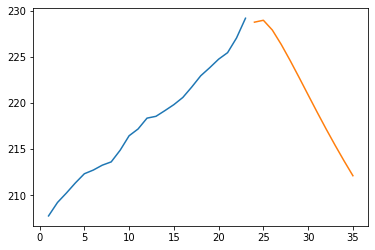

In [ ]:
plt.plot(month_new,scaler.inverse_transform(df1[196:219]))
plt.plot(month_pred,scaler.inverse_transform(list_output))

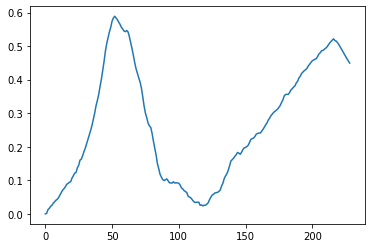

In [ ]:
df3 = df1[:217].tolist()
df3.extend(list_output)
plt.plot(df3)

In [ ]:
print(scaler.inverse_transform(list_output))

[[248.84581371]
 [248.71309372]
 [246.15000717]
 [242.59277527]
 [238.69084356]
 [234.67559262]
 [230.67927424]
 [226.79973265]
 [223.09095625]
 [219.56803585]
 [216.22542496]
 [213.05312304]]


In [ ]:
print(scaler.inverse_transform(df1[229:242]))

[[256.19233444]
 [260.74244789]
 [266.31273152]
 [273.2801407 ]
 [281.68095655]
 [289.63333011]
 [296.82988156]
 [304.12471465]
 [309.71339095]
 [315.99761266]
 [321.81342782]]


In [ ]:
df_out = df1[:193].tolist()
df_out.extend(list_output)

print(scaler.inverse_transform(df_out))


In [ ]:
math.sqrt(mean_squared_error(scaler.inverse_transform(df1[228:242]),scaler.inverse_transform(list_output)))

63.97082842175826

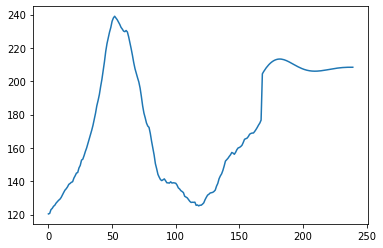

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

In [ ]:
# Make copy of original data
df_orig33 = pd.read_csv('/content/Model_Tampa_Prediction_6months.csv')
df_orig33

,DATE,TPXRSA
0,2002-01-01,120.395793
1,2002-02-01,120.700034
2,2002-03-01,122.958147
3,2002-04-01,123.707047
4,2002-05-01,124.950321
...,...,...
241,2022-02-01,295.493895
242,2022-03-01,285.777483
243,2022-04-01,272.348633
244,2022-05-01,257.288102


In [ ]:
output1_df = pd.DataFrame(df3, columns=['Sale Price'])
output1_df

,Sale Price
0,120.395793
1,120.700034
2,122.958147
3,123.707047
4,124.950321
...,...
241,295.493895
242,285.777483
243,272.348633
244,257.288102


In [ ]:
test_df = df_orig.copy()
test_df['TXP'] = output1_df

In [ ]:
result = [output1_df, df_orig]
new_df = pd.concat(result, axis =1)

In [ ]:
new_df = new_df.drop(['TPXRSA'], axis =1 )

In [ ]:
new_df

,Sale Price,DATE
0,120.395793,2002-01-01
1,120.700034,2002-02-01
2,122.958147,2002-03-01
3,123.707047,2002-04-01
4,124.950321,2002-05-01
...,...,...
241,295.493895,NaN
242,285.777483,NaN
243,272.348633,NaN
244,257.288102,NaN


In [ ]:
#new_df['DATE'] = pd.to_datetime(new_df['DATE'])
#new_df = new_df.set_index('DATE')
#new_df.index = new_df.index.to_period("1M")


In [ ]:
#new_df = new_df.drop(['TPXRSA'], axis =1 )

In [ ]:
#new_date_range = pd.date_range(start="2002-01", end='2023-01', freq="M")
#new_date_range = pd.Series(pd.date_range("1/1/2002", freq="M", periods=len(df3)))
#new_df = new_df.reindex(new_date_range, fill_value=0)

In [ ]:
#new_df['Sale Price'] = output1_df['Sale Price']

#new_df = new_df.append(output1_df, ignore_index = True)

In [ ]:
#df_orig1 = df_orig.copy()



TypeError: ignored

In [ ]:
result1 = [new_df, output_df]
new_df = pd.concat(result1, axis =1)


,DATE,TPXRSA,Sale Price
0,2002-01-01,120.395793,NaN
1,2002-02-01,120.700034,NaN
2,2002-03-01,122.958147,NaN
3,2002-04-01,123.707047,NaN
4,2002-05-01,124.950321,NaN
...,...,...,...
481,NaN,NaN,295.493895
482,NaN,NaN,285.777483
483,NaN,NaN,272.348633
484,NaN,NaN,257.288102
